# 🎨 3W Dataset Visualization Techniques

This notebook demonstrates advanced visualization techniques for the 3W oil well dataset using dimensionality reduction methods and statistical analysis.

**Key Features:**
- **complete vizualizzation**: vizualizar samples of each chosen class
- **t-SNE & UMAP**: Dimensionality reduction for pattern discovery with parameter optimization

**Prerequisites:**
- Run `1_data_treatment.ipynb` first to generate windowed time series data
- Ensure processed data is saved in pickle format for optimal performance

In [1]:
# Setup Environment and Imports
import time
import sys
import os

start_time = time.time()

print("🎨 Loading 3W Dataset for Visualization Analysis")
print("=" * 60)

# Add src to path and import modules
sys.path.append("src")

try:
    print("📦 Importing modules...", end=" ", flush=True)
    from src.data_persistence import DataPersistence
    from src.visualization import DataVisualizer, DimensionalityReductionVisualizer
    from src import config
    import pandas as pd
    import numpy as np

    print("✅")

    # Validate configuration
    print("⚙️ Validating configuration...", end=" ", flush=True)
    if hasattr(config, "validate_config"):
        warnings = config.validate_config()
        if warnings:
            print("⚠️")
            for warning in warnings:
                print(f"     • {warning}")
        else:
            print("✅")
    else:
        print("✅")

    print("🔧 Initializing components...", end=" ", flush=True)
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    visualizer = DataVisualizer()
    dim_reducer = DimensionalityReductionVisualizer()
    print("✅")

    print(f"📁 Configuration Summary:")
    print(f"   • Save format: {config.SAVE_FORMAT}")
    print(f"   • Data directory: {config.PROCESSED_DATA_DIR}")

except Exception as e:
    print(f"❌ Setup failed: {e}")
    raise

🎨 Loading 3W Dataset for Visualization Analysis
📦 Importing modules... ✅
⚙️ Validating configuration... ✅
🔧 Initializing components... ✅
📁 Configuration Summary:
   • Save format: pickle
   • Data directory: processed_data


## Visualization for Time Series

**Challenges with high-dimensional time series:**
- **Curse of dimensionality** - Hard to visualize >3D data
- **Pattern discovery** - Hidden structures in sensor data
- **Class separability** - Understanding which features distinguish faults

**Visualization benefits:**
- **Data understanding** - See actual sensor patterns per fault type
- **Algorithm selection** - Choose models based on data structure
- **Quality assessment** - Identify noise, outliers, mislabeled data
- **Feature engineering** - Discover which sensors are most informative

In [2]:
# Load Windowed Data
try:
    print("📊 Loading windowed test data...")
    load_start = time.time()

    # Load data from first available fold using the existing visualizer
    test_dfs, test_classes, metadata = dim_reducer.load_windowed_data(
        persistence, config
    )

    load_time = time.time() - load_start
    print(f"✅ Data loaded successfully!")
    print(f"   • Format: {metadata['format']}")
    print(f"   • Fold: {metadata['fold_number']}")
    print(f"   • Windows: {metadata['windows_count']}")
    print(f"   • Load time: {load_time:.3f}s")

    # Quick data validation
    if test_dfs and len(test_dfs) > 0:
        sample_window = test_dfs[0]
        sample_class = test_classes[0] if test_classes else "Unknown"

except Exception as e:
    print(f"❌ Data loading failed: {e}")
    print("💡 Troubleshooting:")
    print("   • Ensure '1_data_treatment.ipynb' completed successfully")
    print("   • Check if processed_data directory exists")

    test_dfs, test_classes = None, None
    import traceback

    traceback.print_exc()

📊 Loading windowed test data...
📊 Loading windowed data...
   • Windowed directory: processed_data\cv_splits\windowed
   • Loading from fold_1
   ✅ Loaded 4794 windows from fold 1
✅ Data loaded successfully!
   • Format: pickle
   • Fold: 1
   • Windows: 4794
   • Load time: 0.421s


## Data Loading for Visualization

**Key considerations:**
- **Memory management** - Time series windows can be large
- **Sampling strategy** - Balance between detail and performance
- **Data validation** - Ensure windowed data maintains temporal structure

**Loading priorities:**
- **Test data focus** - Analyze real data that models will encounter
- **Class balance** - Ensure all fault types represented
- **Metadata preservation** - Keep windowing and preprocessing information

## Complete Data Visualization

**Purpose:**
- **Temporal patterns** - See how sensors behave over time for each fault
- **Correlation analysis** - Understand relationships between pressure/temperature
- **Baseline establishment** - Compare normal vs abnormal behavior

**What to look for:**
- **Normal class (0)** - Stable, regular patterns
- **Fault classes (1-8)** - Distinctive anomalous behaviors
- **Sensor interactions** - How different sensors respond to same fault

🎨 Window Sensor Data Visualization
🏷️ Processing class labels...
🏷️ Original class distribution: {np.int16(0): np.int64(1142), np.int16(1): np.int64(2), np.int16(2): np.int64(3), np.int16(3): np.int64(242), np.int16(4): np.int64(136), np.int16(5): np.int64(1), np.int16(6): np.int64(7), np.int16(7): np.int64(7), np.int16(8): np.int64(23), np.int16(101): np.int64(52), np.int16(102): np.int64(20), np.int16(105): np.int64(58), np.int16(106): np.int64(3), np.int16(107): np.int64(2826), np.int16(108): np.int64(272)}
🔄 Mapped 3231 points with transient classes
🏷️ Mapped class distribution: {np.int64(0): np.int64(1142), np.int64(1): np.int64(54), np.int64(2): np.int64(23), np.int64(3): np.int64(242), np.int64(4): np.int64(136), np.int64(5): np.int64(59), np.int64(6): np.int64(10), np.int64(7): np.int64(2833), np.int64(8): np.int64(295)}
📊 Creating window Sensor Data Visualizations
📈 Visualizing 2 samples for each of 9 classes

🎯 Class 0:
   📊 Showing 2 samples (out of 1142 available)


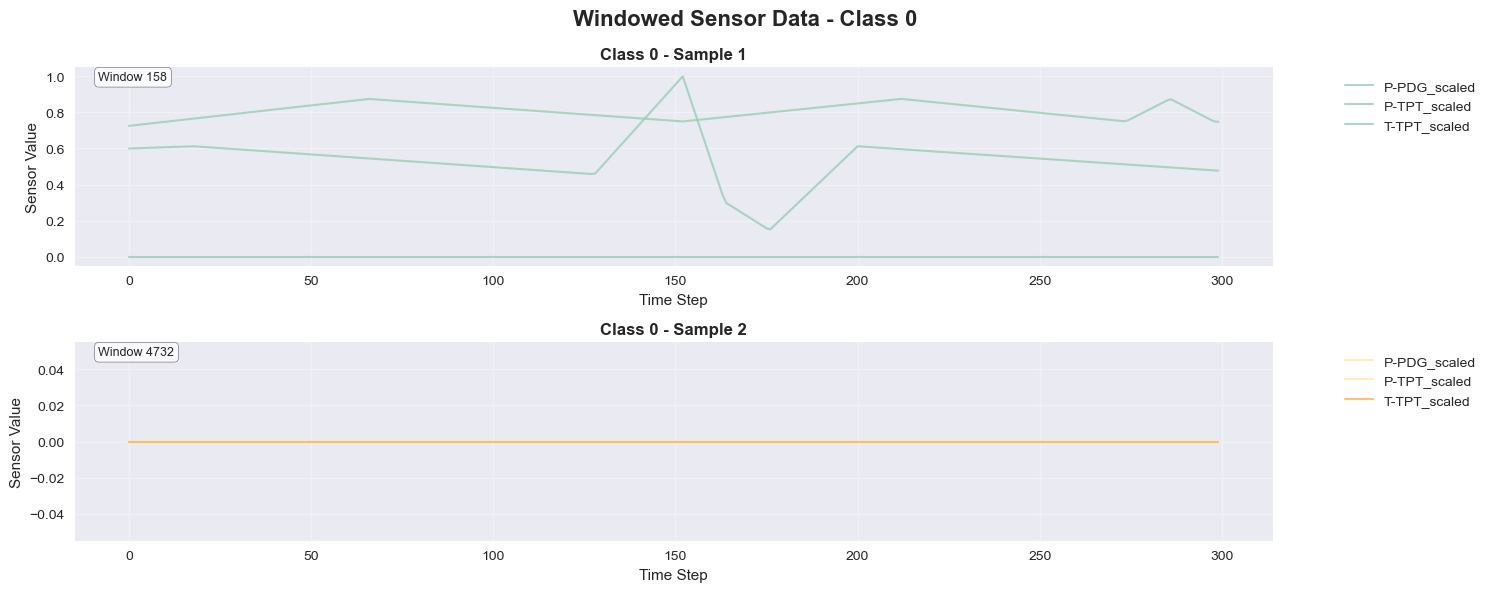

   ✅ Displayed 2 samples for class 0

🎯 Class 1:
   📊 Showing 2 samples (out of 54 available)


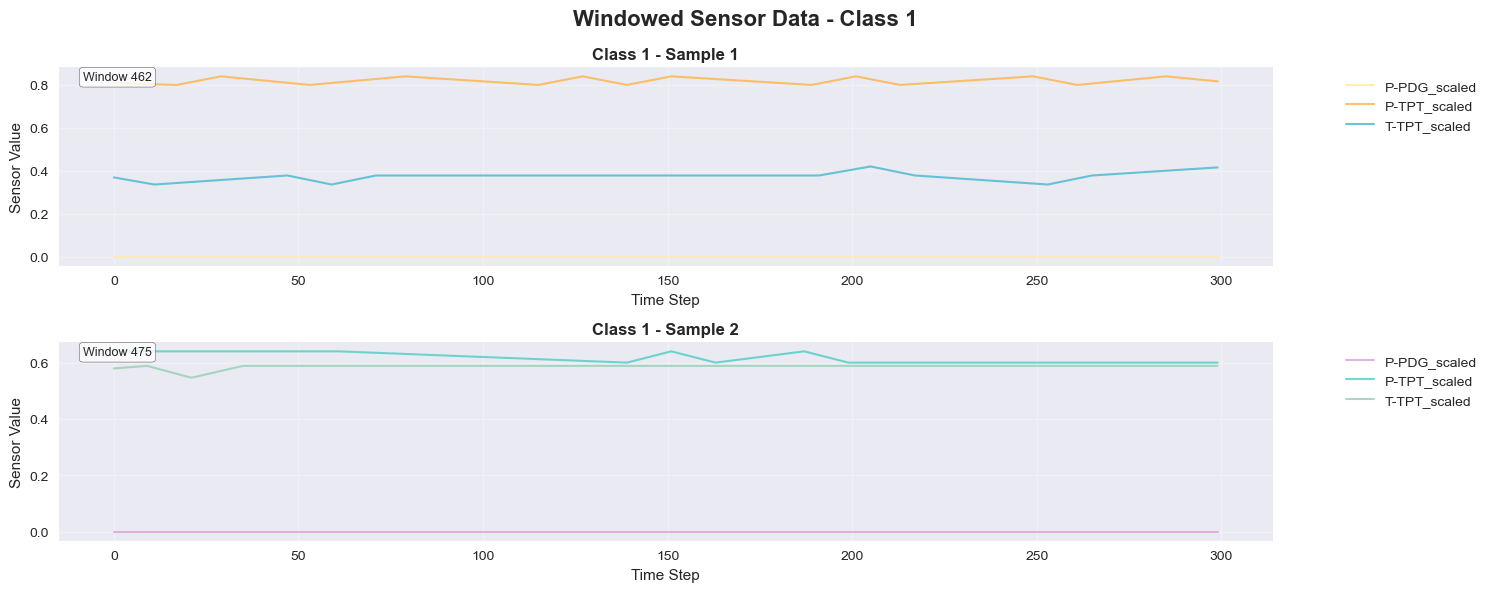

   ✅ Displayed 2 samples for class 1

🎯 Class 2:
   📊 Showing 2 samples (out of 23 available)


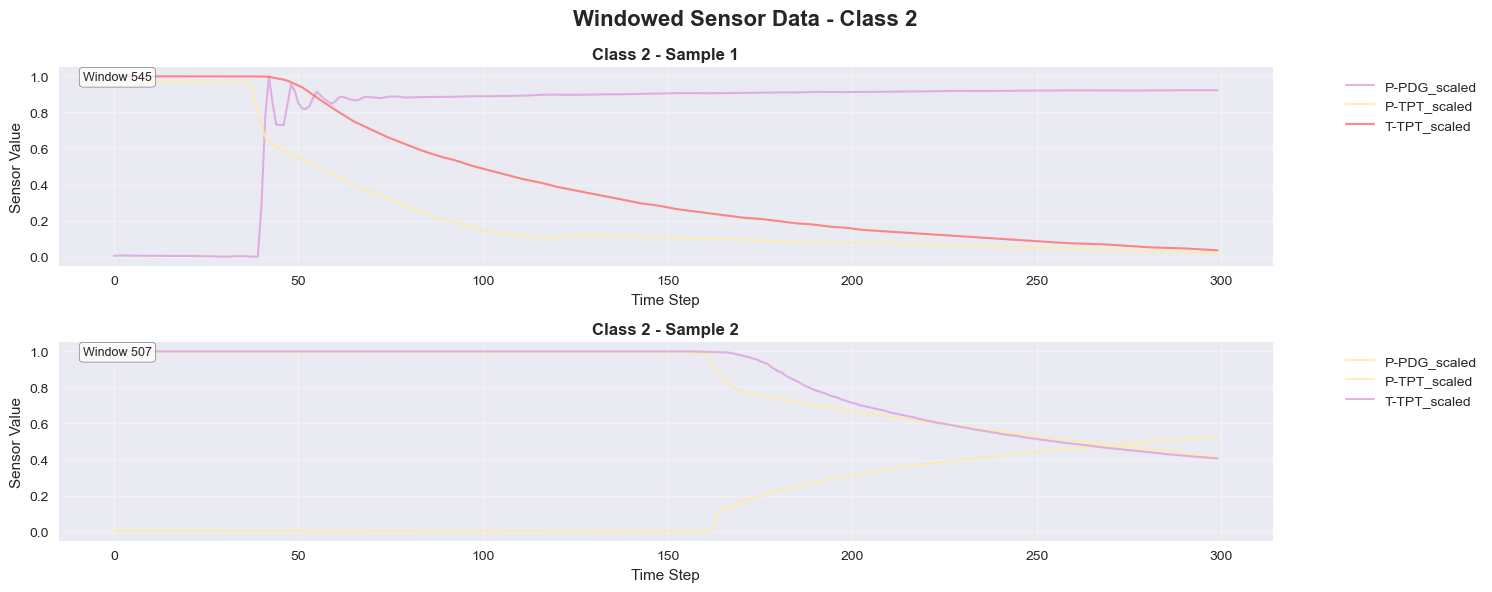

   ✅ Displayed 2 samples for class 2

🎯 Class 3:
   📊 Showing 2 samples (out of 242 available)


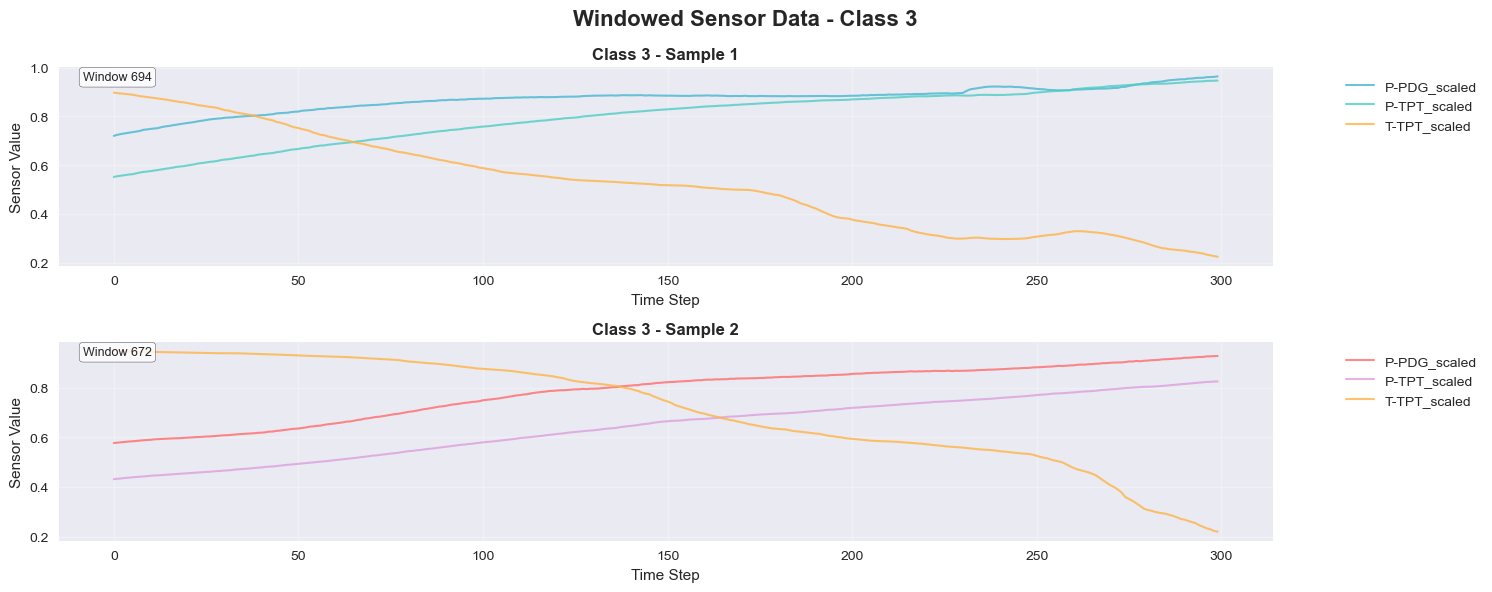

   ✅ Displayed 2 samples for class 3

🎯 Class 4:
   📊 Showing 2 samples (out of 136 available)


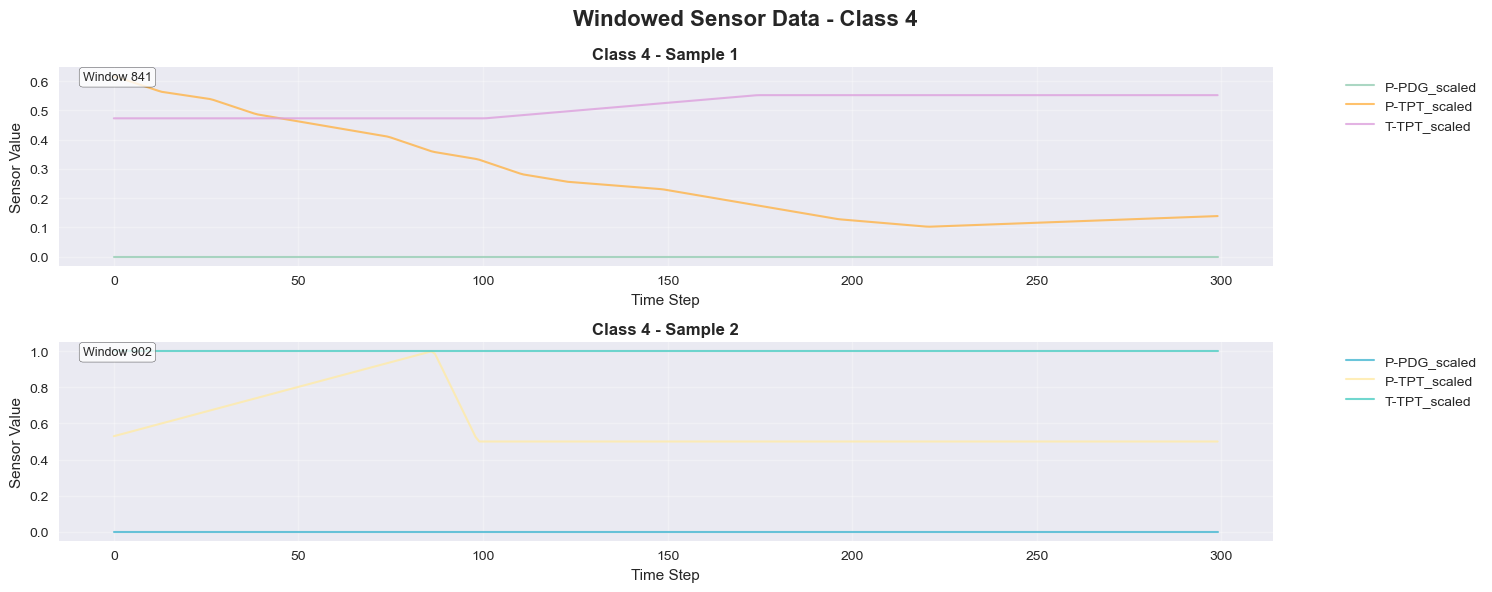

   ✅ Displayed 2 samples for class 4

🎯 Class 5:
   📊 Showing 2 samples (out of 59 available)


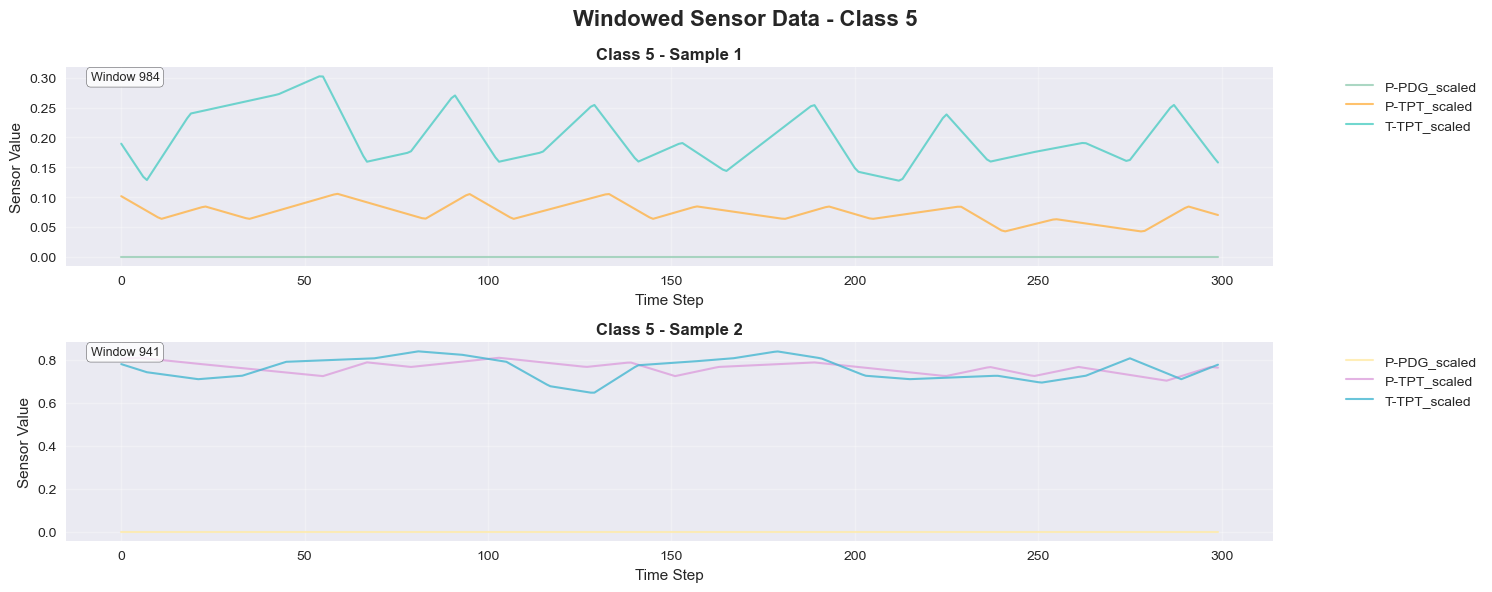

   ✅ Displayed 2 samples for class 5

🎯 Class 6:
   📊 Showing 2 samples (out of 10 available)


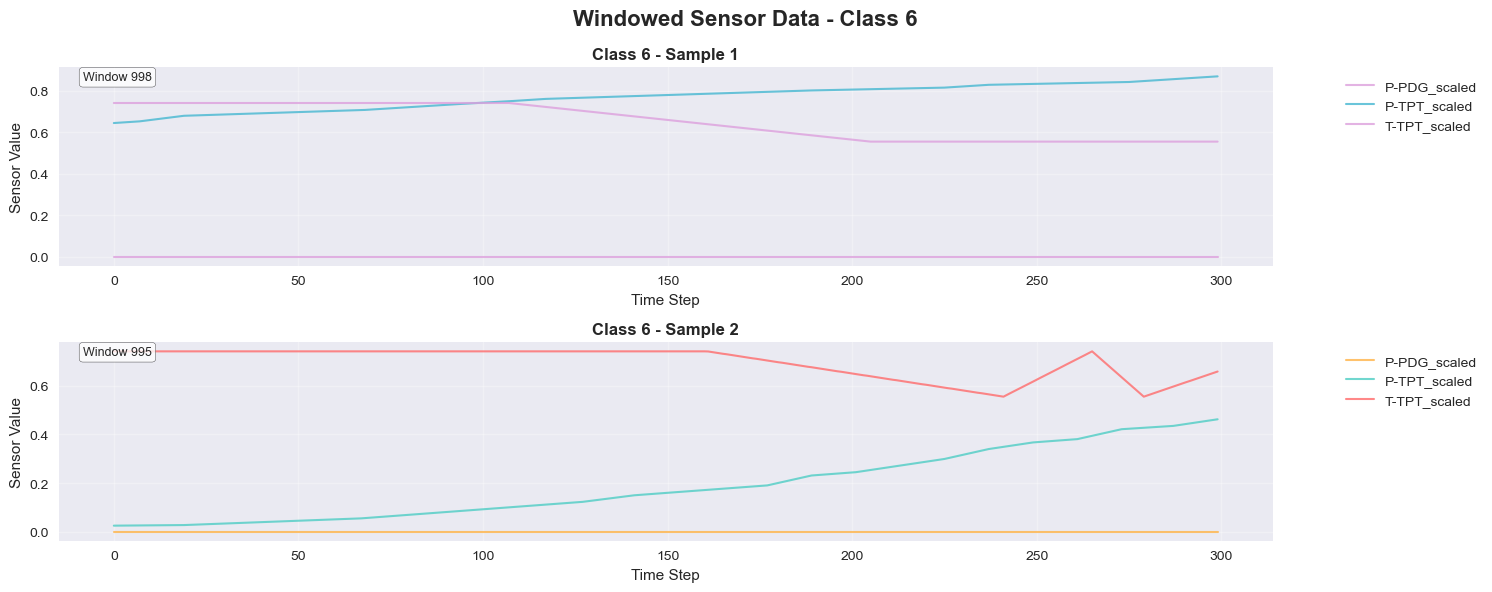

   ✅ Displayed 2 samples for class 6

🎯 Class 7:
   📊 Showing 2 samples (out of 2833 available)


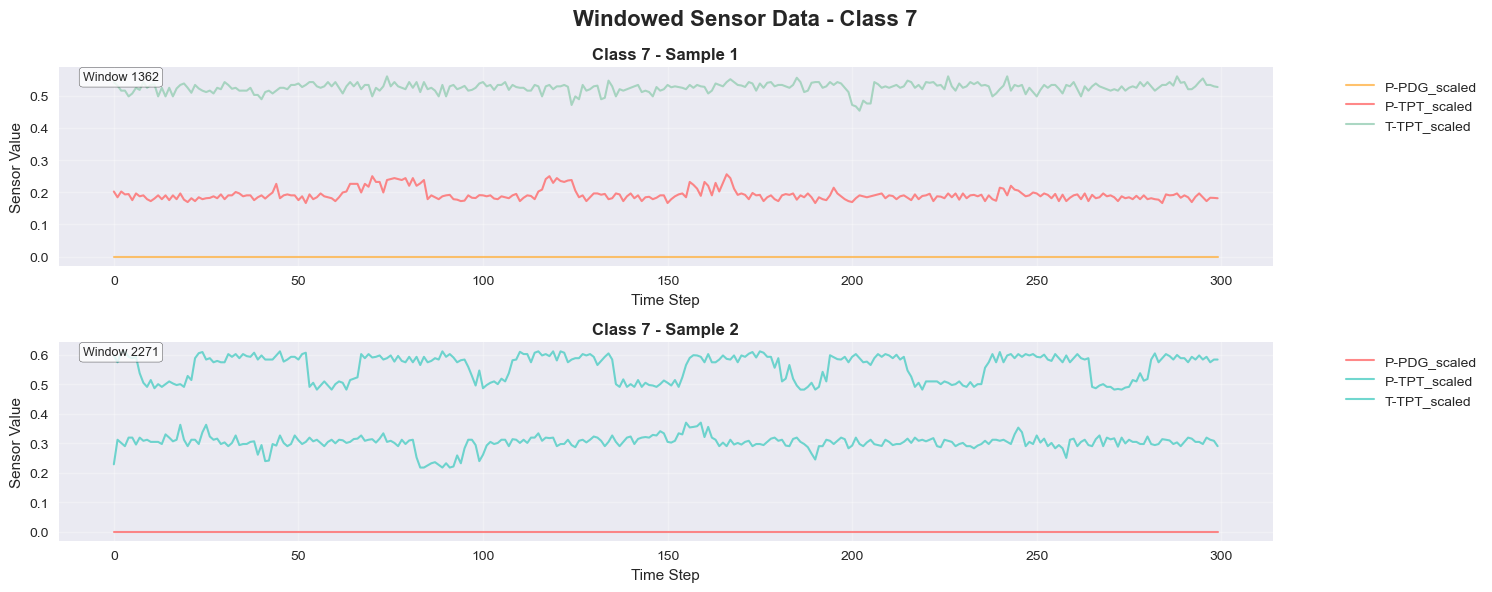

   ✅ Displayed 2 samples for class 7

🎯 Class 8:
   📊 Showing 2 samples (out of 295 available)


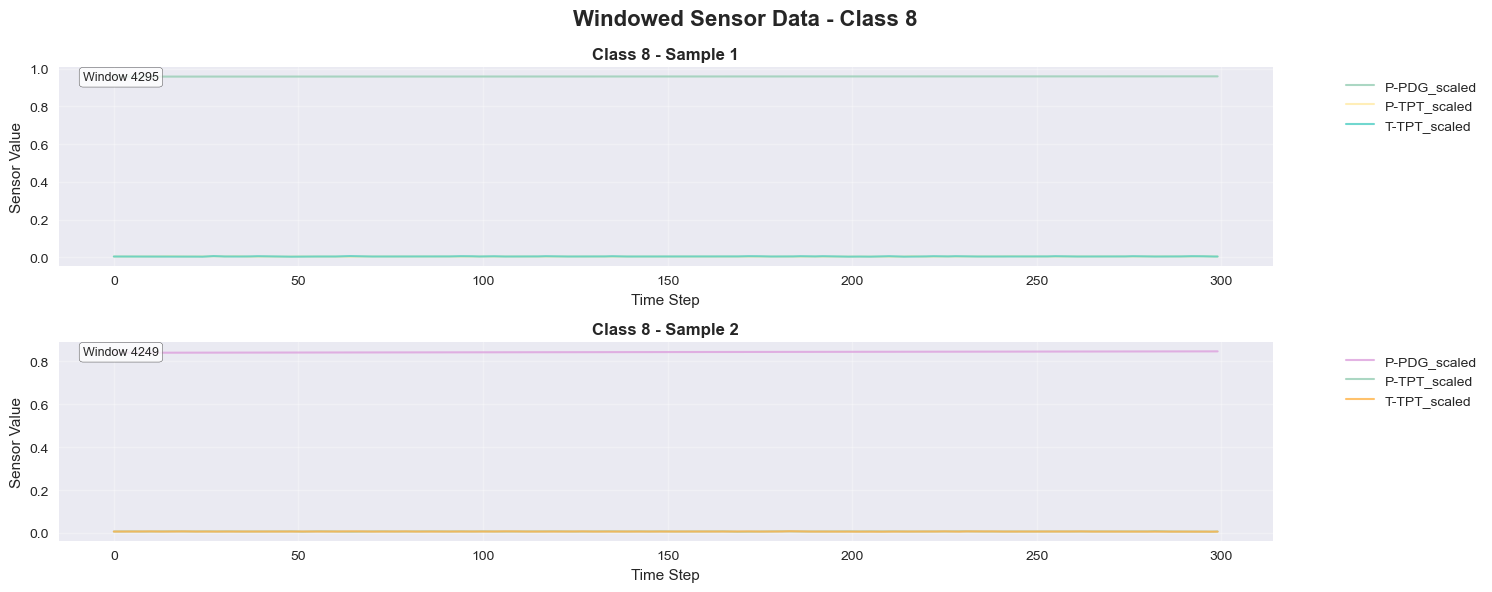

   ✅ Displayed 2 samples for class 8


In [3]:
# Complete Visualization: Sample Sensor Data for Each Class
if test_dfs is not None and "test_classes" in locals():
    print("🎨 Window Sensor Data Visualization")
    print("=" * 60)

    try:
        # Extract and map class labels first
        mapped_classes = dim_reducer.extract_and_map_classes(test_dfs, test_classes)

        # Set random seed for reproducible sampling
        np.random.seed(42)

        # Visualize complete samples for each class (5 samples per class)
        dim_reducer.visualize_window_samples(test_dfs, mapped_classes, samples_per_class=2)

    except Exception as e:
        print(f"❌ Complete visualization failed: {e}")
        import traceback

        traceback.print_exc()
else:
    print("❌ Cannot create complete visualizations: No test data available")
    print("Please ensure the data loading completed successfully")

## Data Preprocessing for Dimensionality Reduction

**Why preprocess for visualization?**
- **Feature standardization** - Ensure all sensors contribute equally
- **Sampling strategy** - Balance computational cost vs. detail
- **Format transformation** - Convert time windows to feature vectors

**Steps:**
1. **Flatten windows** - Convert 2D time series to 1D feature vectors
2. **Standardize features** - Zero mean, unit variance
3. **Intelligent sampling** - Balance classes while reducing dataset size

In [4]:
# Extract and Process Class Labels
if test_dfs is not None:
    try:
        # Extract and map class labels using existing methods
        mapped_classes = dim_reducer.extract_and_map_classes(test_dfs, test_classes)
        print("✅ Class processing complete")

    except Exception as e:
        print(f"❌ Class processing failed: {e}")
        mapped_classes = None

🏷️ Processing class labels...
🏷️ Original class distribution: {np.int16(0): np.int64(1142), np.int16(1): np.int64(2), np.int16(2): np.int64(3), np.int16(3): np.int64(242), np.int16(4): np.int64(136), np.int16(5): np.int64(1), np.int16(6): np.int64(7), np.int16(7): np.int64(7), np.int16(8): np.int64(23), np.int16(101): np.int64(52), np.int16(102): np.int64(20), np.int16(105): np.int64(58), np.int16(106): np.int64(3), np.int16(107): np.int64(2826), np.int16(108): np.int64(272)}
🔄 Mapped 3231 points with transient classes
🏷️ Mapped class distribution: {np.int64(0): np.int64(1142), np.int64(1): np.int64(54), np.int64(2): np.int64(23), np.int64(3): np.int64(242), np.int64(4): np.int64(136), np.int64(5): np.int64(59), np.int64(6): np.int64(10), np.int64(7): np.int64(2833), np.int64(8): np.int64(295)}
✅ Class processing complete


## Dimensionality Reduction Theory

**The challenge:** Time series windows create high-dimensional data (e.g., 100 timesteps × 5 sensors = 500 features)

**Dimensionality reduction goals:**
- **Visualization** - Project to 2D/3D for human interpretation
- **Pattern discovery** - Reveal hidden structures and clusters
- **Noise reduction** - Focus on most informative dimensions

**Method comparison:**
- **t-SNE** - Excellent for cluster visualization, preserves local neighborhoods
- **UMAP** - Faster, preserves both local and global structure, more deterministic
- **Parameter sensitivity** - Both require tuning for optimal results

**Applications:**
- **Class separability** - See if fault types form distinct clusters
- **Outlier detection** - Identify unusual samples
- **Feature importance** - Understand which sensor patterns matter most

In [ ]:
# Intelligent Sampling and Feature Extraction
if mapped_classes is not None:
    try:
        # Perform intelligent sampling using existing methods
        selected_test_dfs, selected_classes, sampling_summary = (
            dim_reducer.intelligent_sampling_for_visualization(
                test_dfs, mapped_classes, config
            )
        )

        # Extract and standardize features
        X_scaled, y_labels, scaler = dim_reducer.prepare_features_for_visualization(
            selected_test_dfs, selected_classes
        )

        print(f"\n📈 Final Dataset Summary:")
        print(f"   • Samples: {X_scaled.shape[0]} (balanced)")
        print(f"   • Features: {X_scaled.shape[1]} (standardized)")
        print(f"   • Classes: {sorted(np.unique(y_labels))}")
        print(f"   • Memory: {X_scaled.nbytes / 1024 / 1024:.2f} MB")

        unique_classes = np.unique(y_labels)
        print("✅ Data preparation complete - ready for visualization!")

    except Exception as e:
        print(f"❌ Feature extraction failed: {e}")
        X_scaled, y_labels = None, None
        import traceback

        traceback.print_exc()
else:
    X_scaled, y_labels = None, None

🎯 Performing intelligent sampling...
   • Selected 400 windows
   • Sampling summary: {0: {'available': 1142, 'sampled': 100}, 3: {'available': 242, 'sampled': 100}, 4: {'available': 136, 'sampled': 100}, 8: {'available': 295, 'sampled': 100}}
🔄 Preparing features for visualization...
   • Features: 3 sensors × 300 timesteps
   • Feature matrix: (400, 900)
   • Memory usage: 2.75 MB

📈 Final Dataset Summary:
   • Samples: 400 (balanced)
   • Features: 900 (standardized)
   • Classes: [np.int64(0), np.int64(3), np.int64(4), np.int64(8)]
   • Memory: 2.75 MB
✅ Data preparation complete - ready for visualization!


## t-SNE Implementation

**t-SNE (t-Distributed Stochastic Neighbor Embedding):**
- **Local structure focus** - Preserves neighborhoods between similar points
- **Non-linear mapping** - Can reveal complex, curved decision boundaries
- **Perplexity parameter** - Controls local vs global emphasis (typical: 5-50)

**Strengths:**
- **Excellent clustering** - Clear separation of different classes
- **Intuitive results** - Often produces visually appealing clusters

**Limitations:**
- **Slow computation** - O(n²) complexity
- **Random initialization** - Results can vary between runs
- **Global structure loss** - May not preserve overall data relationships

🔮 t-SNE: Non-linear Dimensionality Reduction
🔮 Running t-SNE analysis...
   • t-SNE #1: perplexity=30, lr=200...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


     ✅ Completed in 0.5s
   • t-SNE #2: perplexity=10, lr=100...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


     ✅ Completed in 0.4s
   • t-SNE #3: perplexity=50, lr=300...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


     ✅ Completed in 0.5s
   • t-SNE #4: perplexity=30, lr=500...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


     ✅ Completed in 0.5s


c:\Users\lucas\Documents\GitHub\3W\resources\introduction_to_ml_applied_to_mts\src\visualization.py:1565: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


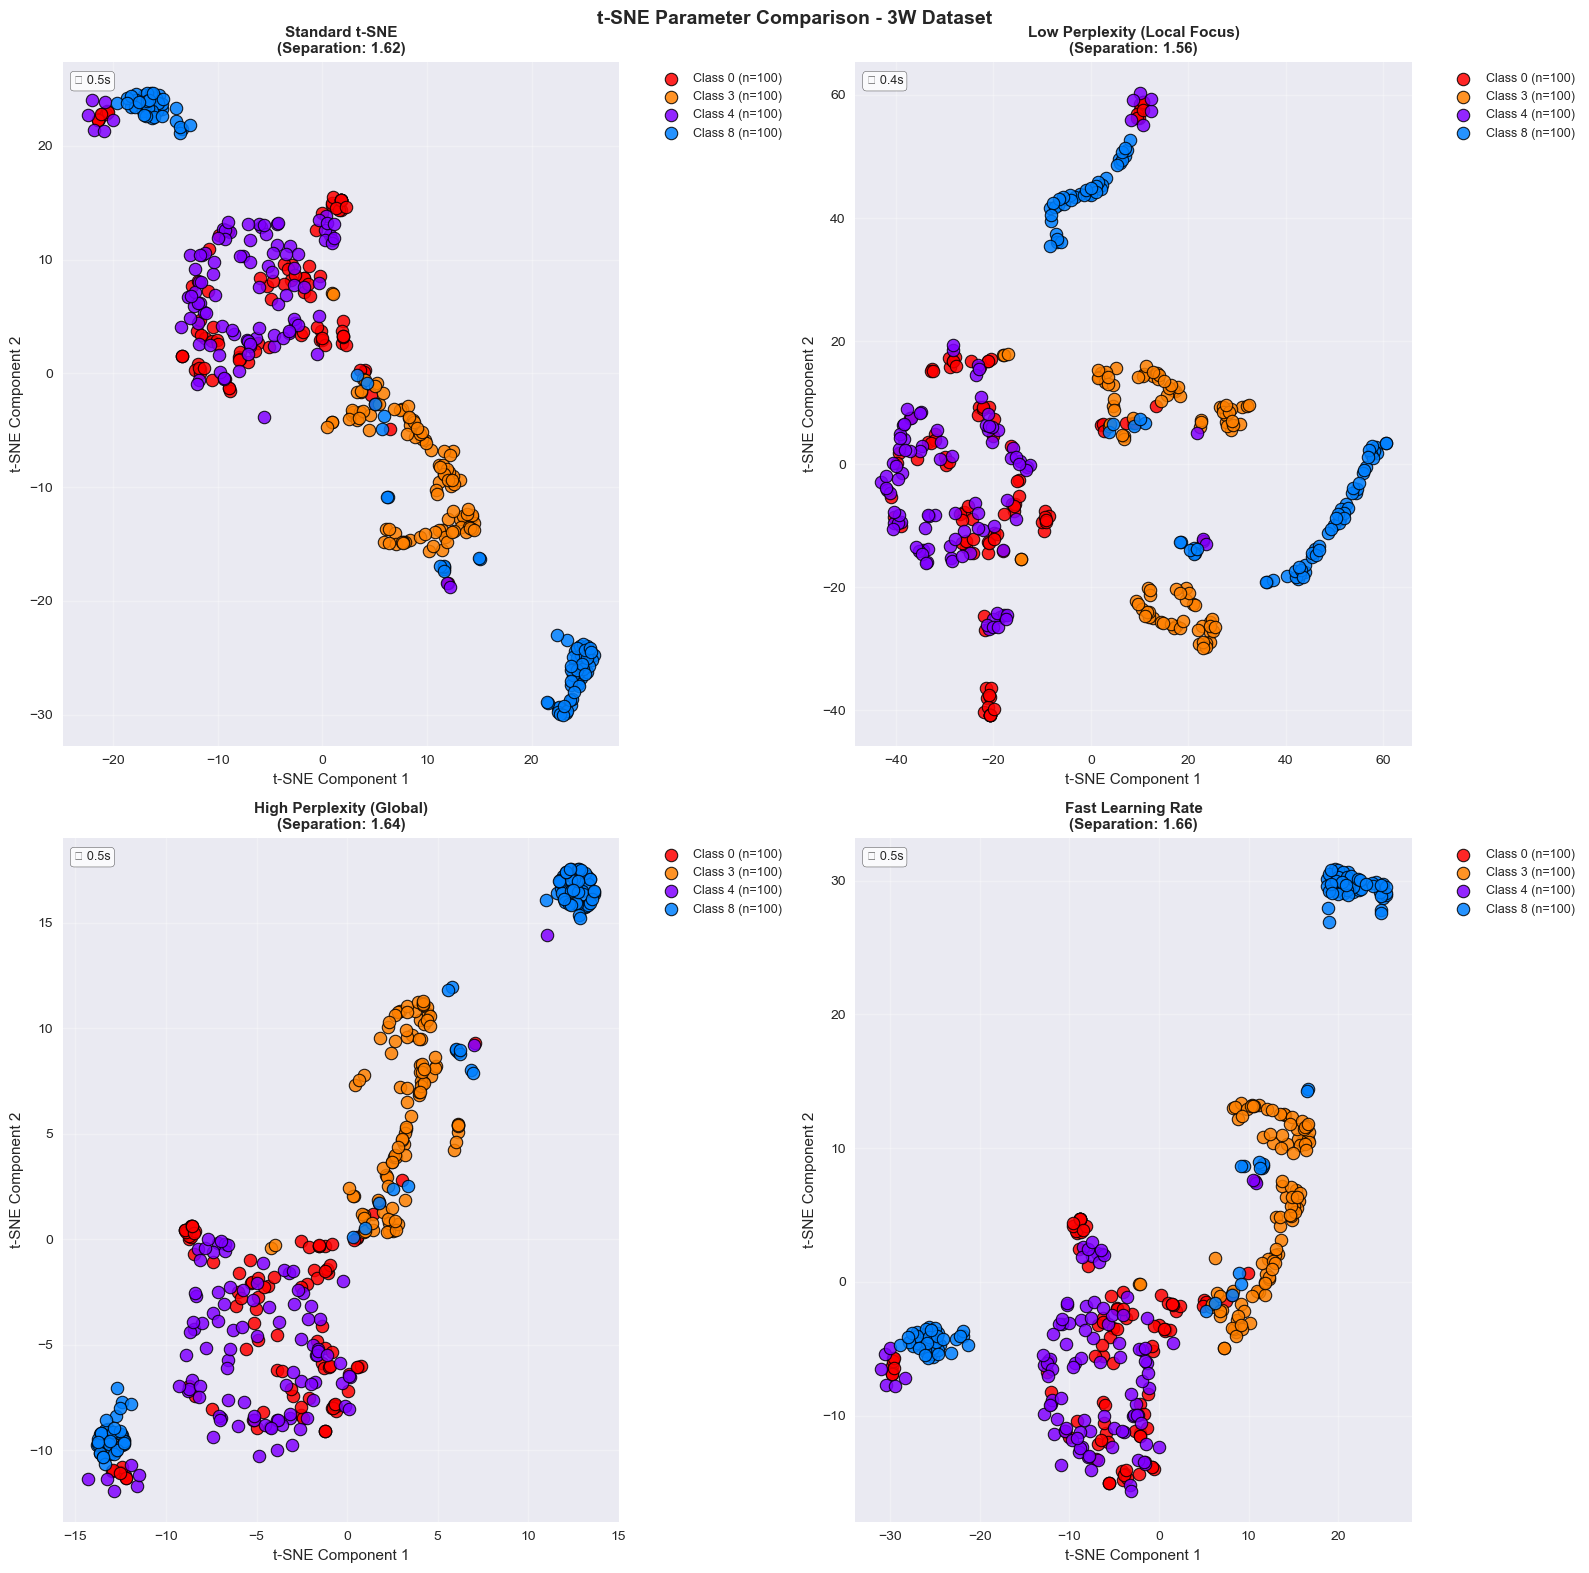


📊 t-SNE Analysis Results:
⚡ Configuration Performance:
   • Config 1: 0.5s
   • Config 2: 0.4s ⚡ Fastest
   • Config 3: 0.5s
   • Config 4: 0.5s


In [12]:
# t-SNE Visualization Analysis
if X_scaled is not None and y_labels is not None:
    print("🔮 t-SNE: Non-linear Dimensionality Reduction")
    print("=" * 60)

    # Run t-SNE analysis using existing methods
    tsne_results = dim_reducer.run_tsne_analysis(X_scaled, y_labels)

    # Create visualizations
    fig = dim_reducer.plot_dimensionality_reduction_results(
        tsne_results, y_labels, "t-SNE"
    )

    # Print performance summary
    dim_reducer.print_dimensionality_reduction_summary(tsne_results, "t-SNE")

else:
    print("❌ Cannot run t-SNE: No processed data available")
    print("Please ensure the data preparation completed successfully")

## Visualization Insights & Next Steps

**What we learned:**
- **Class separability** - How well different fault types can be distinguished
- **Data quality** - Identified outliers, noise, and potential mislabeling
- **Feature relevance** - Which sensor combinations are most informative
- **Algorithm suitability** - Whether linear or non-linear models are needed

**Actionable insights for ML:**
- **Well-separated clusters** → Simple classifiers (SVM, Random Forest) may work well
- **Complex boundaries** → Deep learning or ensemble methods needed
- **Overlapping classes** → Feature engineering or data augmentation required
- **Clear patterns** → Good prospects for accurate fault detection

**Next steps:**
- **Supervised learning** (notebook 3) - Build classification models
- **Unsupervised learning** (notebook 4) - Explore anomaly detection
- **Feature engineering** - Based on discovered patterns

# NEXT STEPS - UMAP

## UMAP Implementation

**UMAP (Uniform Manifold Approximation and Projection):**
- **Global + local structure** - Preserves both neighborhood and overall topology
- **Faster computation** - More scalable to large datasets
- **Deterministic** - Consistent results with same parameters

**Key parameters:**
- **n_neighbors** - Local neighborhood size (typical: 5-50)
- **min_dist** - Minimum distance between points in 2D space
- **metric** - Distance function (euclidean, cosine, etc.)

**Advantages:**
- **Speed** - Much faster than t-SNE for large datasets
- **Stability** - More consistent results across runs
- **Interpretability** - Better preserves global relationships

In [13]:
# Check UMAP Availability
try:
    import umap

    umap_available = True
    print("✅ UMAP library available")
except ImportError:
    umap_available = False
    print("❌ UMAP not available")
    print("📦 Install with: pip install umap-learn")
    print("🔄 Attempting installation...")

    try:
        import subprocess
        import sys

        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "umap-learn"],
            capture_output=True,
            text=True,
        )
        import umap

        umap_available = True
        print("✅ UMAP installed successfully")
    except Exception as e:
        print(f"❌ Installation failed: {e}")
        print("⚠️ Continuing without UMAP")

✅ UMAP library available


🚀 UMAP: Uniform Manifold Approximation
🚀 Running UMAP analysis...
   • UMAP #1: neighbors=15, dist=0.1...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


     ✅ Completed in 0.2s
   • UMAP #2: neighbors=5, dist=0.0...
     ✅ Completed in 0.2s
   • UMAP #3: neighbors=50, dist=0.5...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


     ✅ Completed in 0.3s
   • UMAP #4: neighbors=30, dist=0.25...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


     ✅ Completed in 0.3s


c:\Users\lucas\Documents\GitHub\3W\resources\introduction_to_ml_applied_to_mts\src\visualization.py:1565: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


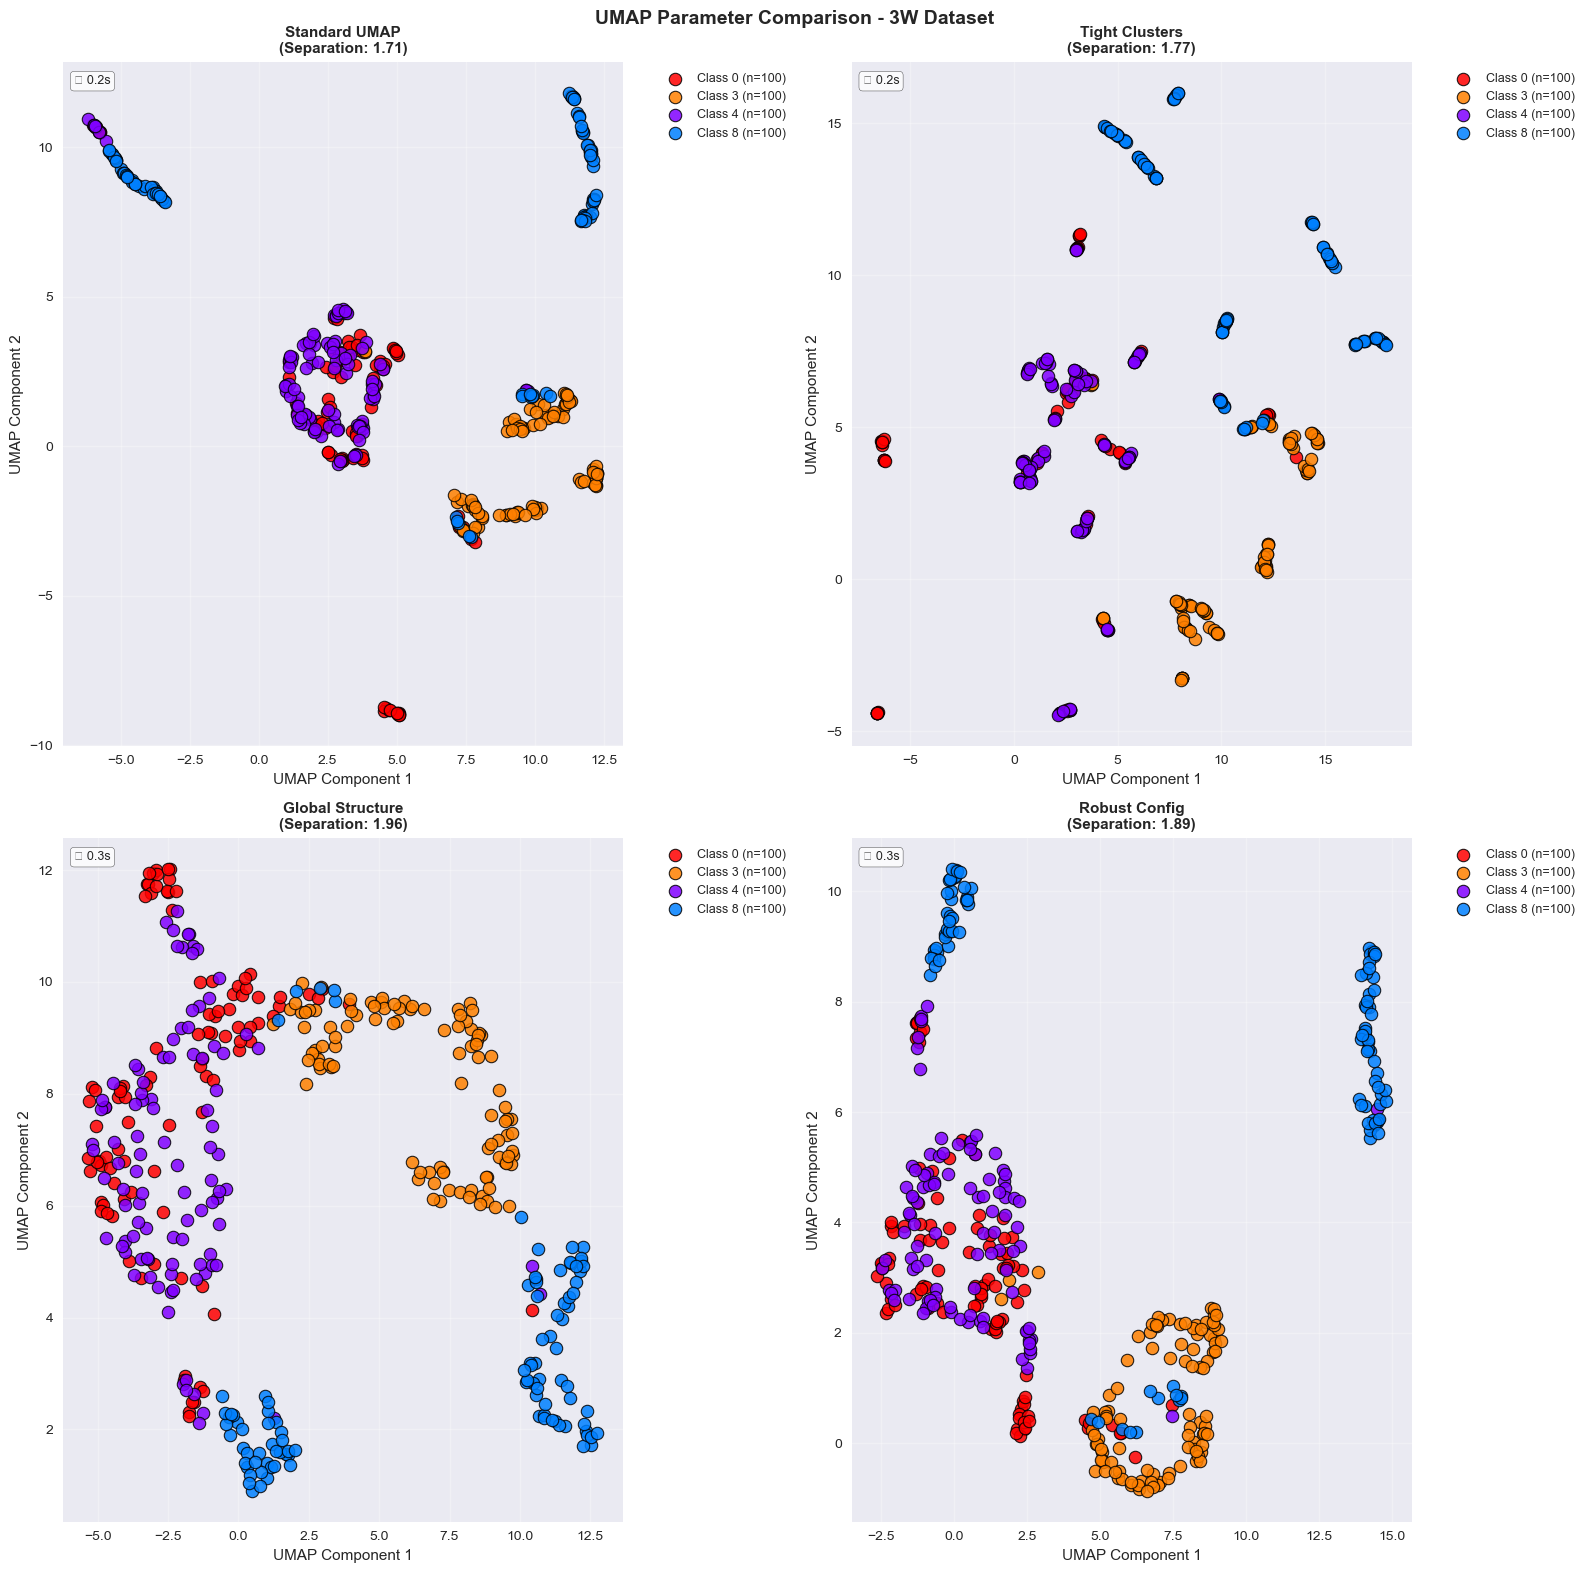


📊 UMAP Analysis Results:
⚡ Configuration Performance:
   • Config 1: 0.2s
   • Config 2: 0.2s ⚡ Fastest
   • Config 3: 0.3s
   • Config 4: 0.3s


In [14]:
# UMAP Visualization Analysis
if X_scaled is not None and y_labels is not None and umap_available:
    print("🚀 UMAP: Uniform Manifold Approximation")
    print("=" * 60)

    # Run UMAP analysis using existing methods
    umap_results = dim_reducer.run_umap_analysis(X_scaled, y_labels)

    if umap_results:
        # Create visualizations
        fig = dim_reducer.plot_dimensionality_reduction_results(
            umap_results, y_labels, "UMAP"
        )

        # Print performance summary
        dim_reducer.print_dimensionality_reduction_summary(umap_results, "UMAP")

elif not umap_available:
    print("❌ UMAP not available. Skipping UMAP analysis.")
else:
    print("❌ Cannot run UMAP: No processed data available")

## Method Comparison Analysis

**Choosing the right method:**

**Use t-SNE when:**
- **Small-medium datasets** (<10k samples)
- **Focus on clustering** - Want clear class separation
- **Exploratory analysis** - Looking for hidden patterns
- **Computational time not critical**

**Use UMAP when:**
- **Large datasets** (>10k samples)
- **Global structure matters** - Need to preserve overall relationships
- **Reproducibility required** - Consistent results needed
- **Speed is important** - Production visualization systems

**Interpretation guidelines:**
- **Tight clusters** - Strong class separability, good for classification
- **Overlapping regions** - Challenging classification boundaries
- **Outliers** - Potential data quality issues or rare patterns

In [15]:
# Method Comparison and Analysis
print("📊 Dimensionality Reduction Method Comparison")
print("=" * 60)

# Compare methods if both are available
if "tsne_results" in locals() and "umap_results" in locals():
    print("🏆 t-SNE vs UMAP Performance Comparison:")

    # Calculate average times
    tsne_times = [r["time"] for r in tsne_results if r["time"] is not None]
    umap_times = (
        [r["time"] for r in umap_results if r["time"] is not None]
        if umap_results
        else []
    )

    if tsne_times:
        avg_tsne_time = np.mean(tsne_times)
        print(f"   • t-SNE average time: {avg_tsne_time:.1f}s")

    if umap_times:
        avg_umap_time = np.mean(umap_times)
        print(f"   • UMAP average time: {avg_umap_time:.1f}s")

        if tsne_times:
            speedup = avg_tsne_time / avg_umap_time
            print(f"   • UMAP speedup: {speedup:.1f}x faster")

    print(f"\n📈 Method Characteristics:")
    print(f"   🔮 t-SNE:")
    print(f"      • Excellent for local structure preservation")
    print(f"      • Great for cluster visualization")
    print(f"      • Sensitive to perplexity parameter")
    print(f"      • Computationally intensive")

    if umap_available:
        print(f"   🚀 UMAP:")
        print(f"      • Preserves both local and global structure")
        print(f"      • Faster computation")
        print(f"      • More scalable to large datasets")
        print(f"      • Deterministic results")

print(f"\n✅ Visualization analysis complete!")
print(f"📝 Key insights:")
print(f"   • Both methods revealed class separability patterns")
print(f"   • Parameter tuning affects cluster quality")
print(f"   • Different metrics capture different data aspects")

📊 Dimensionality Reduction Method Comparison
🏆 t-SNE vs UMAP Performance Comparison:
   • t-SNE average time: 0.5s
   • UMAP average time: 0.2s
   • UMAP speedup: 2.0x faster

📈 Method Characteristics:
   🔮 t-SNE:
      • Excellent for local structure preservation
      • Great for cluster visualization
      • Sensitive to perplexity parameter
      • Computationally intensive
   🚀 UMAP:
      • Preserves both local and global structure
      • Faster computation
      • More scalable to large datasets
      • Deterministic results

✅ Visualization analysis complete!
📝 Key insights:
   • Both methods revealed class separability patterns
   • Parameter tuning affects cluster quality
   • Different metrics capture different data aspects


In [16]:
# Summary
print("🎯 Visualization Analysis Summary")
print("=" * 60)

if "X_scaled" in locals() and X_scaled is not None:
    print(f"✅ Successfully analyzed {X_scaled.shape[0]} windowed time series samples")
    print(f"✅ Reduced dimensionality from {X_scaled.shape[1]} to 2D")
    print(f"✅ Visualized {len(np.unique(y_labels))} fault classes")

    # Dataset summary
    print(f"\n📊 Dataset Summary:")
    for class_label in sorted(np.unique(y_labels)):
        count = np.sum(y_labels == class_label)
        percentage = count / len(y_labels) * 100
        print(f"   • Class {class_label}: {count} samples ({percentage:.1f}%)")

    # Available variables
    print(f"\n💾 Available Variables:")
    print(f"   • X_scaled: Standardized feature matrix ({X_scaled.shape})")
    print(f"   • y_labels: Class labels ({len(y_labels)} samples)")
    if "tsne_results" in locals():
        print(f"   • tsne_results: t-SNE analysis results")
    if "umap_results" in locals() and umap_results:
        print(f"   • umap_results: UMAP analysis results")


else:
    print("❌ Analysis incomplete - no processed data available")
    print("🔧 Please run previous cells to generate data")

🎯 Visualization Analysis Summary
✅ Successfully analyzed 400 windowed time series samples
✅ Reduced dimensionality from 900 to 2D
✅ Visualized 4 fault classes

📊 Dataset Summary:
   • Class 0: 100 samples (25.0%)
   • Class 3: 100 samples (25.0%)
   • Class 4: 100 samples (25.0%)
   • Class 8: 100 samples (25.0%)

💾 Available Variables:
   • X_scaled: Standardized feature matrix ((400, 900))
   • y_labels: Class labels (400 samples)
   • tsne_results: t-SNE analysis results
   • umap_results: UMAP analysis results
